In [1]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from statistics import mode



In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Wadu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Wadu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Wadu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
dataset = pd.read_csv(r'D:\Radu\fac\master\PML\Restanta\tweet_emotions.csv')
lista_sentimente_sterse = ['anger', 'boredom', 'enthusiasm', 'hate','empty','relief','fun','surprise']
# Assuming 'dataset' is your DataFrame
df = dataset[~dataset['sentiment'].isin(lista_sentimente_sterse)]

In [4]:

from nltk.stem import WordNetLemmatizer

stemmer = SnowballStemmer('english')

def normalizare(text):
    # eliminare URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # eliminare user @ references and '#' 
    text = re.sub(r'\@\w+|\#','', text)

    # eliminare semne du punctuatie
    text = re.sub(r'[^\w\s]', '', text)

    # text mic
    text = text.lower()

    word_tokens = word_tokenize(text)
    
    # Stemming
    stemmed_tokens = [stemmer.stem(token) for token in word_tokens]
    
    filtered_text = [word for word in stemmed_tokens]
    
    return " ".join(filtered_text)

amaz i manag to get work done visit for more info product


In [5]:
X = df['content'].apply(normalizare)
Y = df['sentiment']

# maparea sentimentelor
id_sentimente = pd.factorize(df['sentiment'])[0]

# convertire intr un numpy array
id_sentimente_array = np.array(id_sentimente)

Y = id_sentimente_array

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [6]:
tf_idf = TfidfVectorizer(ngram_range=(1,1))

X_train_tfidf = tf_idf.fit_transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)

In [7]:
count_vect = CountVectorizer(ngram_range=(1,1))

X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)

In [55]:
#initializarea modelului
dbscan = DBSCAN(
                eps=0.8,
                min_samples=2
               )

#fit
dbscan.fit(X_train_tfidf)


DBSCAN(eps=0.778, min_samples=2)

In [59]:

# aflam core samples
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
core_samples = X_train_tfidf[core_samples_mask]

# initializam si antrenam NN cu un singur vecin
nn_model = NearestNeighbors(n_neighbors=1)
nn_model.fit(core_samples)

#predict pentru datele din test
X_test_transformed = tf_idf.transform(X_test)

distances, indices = nn_model.kneighbors(X_test_transformed) #obtinem distantele si indicii pentru nn

#asociam labels pentru punctele din testare
test_labels = dbscan.labels_[core_samples_mask][indices]

# flatten pentru a obtine array 1D
test_labels = np.ravel(test_labels)


In [60]:
#numarul de clustere
n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
print(n_clusters)

495


In [58]:


def mapare_clustere(y_predicted, y_actual, n_clusters):
    mapping_dict = {}
    mapped_labels = np.zeros_like(y_predicted) 
    
    #pentru fiecare cluster:
    for i in range(n_clusters):
        #mask pentru fiecare cluster
        cluster_mask = (y_predicted == i)
        #daca exista puncte in cluster, determinam cel mai dominant label si al asignam tuturor punctelor din cluster
        if np.any(cluster_mask):
            label_majoritar = mode(y_actual[cluster_mask])
            print(label_majoritar)
            mapped_labels[cluster_mask] = label_majoritar
            mapping_dict[i] = label_majoritar

    return mapped_labels, mapping_dict

# mapare pe train
mapped_train_labels, mapping_dict = mapare_clustere(dbscan.labels_, y_train, n_clusters)

# mapare pe test
mapped_test_labels = np.array([mapping_dict[label] if label in mapping_dict else -1 for label in test_labels])

# calculare classification report
print(classification_report(y_test, mapped_test_labels, target_names=np.unique(Y).astype(str)))


              precision    recall  f1-score   support

           0       0.36      0.03      0.06      1107
           1       0.27      0.92      0.42      1683
           2       0.40      0.05      0.08      1630
           3       0.48      0.14      0.21       809
           4       0.38      0.05      0.09      1034

    accuracy                           0.29      6263
   macro avg       0.38      0.24      0.17      6263
weighted avg       0.37      0.29      0.19      6263



In [61]:

from collections import Counter

labels = dbscan.labels_

#aflam distributia punctelor pentru fiecare cluster
distributie_cluster = Counter(labels)

# calculare noise points
noise_points = distributie_cluster[-1]

print("Distrubutie clustere:", distributie_cluster)
print("Noise points:", noise_points)


Distrubutie clustere: Counter({-1: 22809, 7: 342, 11: 101, 47: 66, 2: 58, 36: 48, 48: 46, 3: 27, 12: 27, 1: 25, 6: 24, 37: 24, 67: 18, 56: 16, 153: 16, 157: 14, 9: 13, 43: 13, 52: 12, 84: 12, 95: 12, 174: 12, 44: 11, 71: 11, 80: 11, 15: 10, 39: 10, 50: 10, 287: 10, 57: 9, 107: 9, 382: 9, 63: 8, 99: 8, 149: 8, 35: 7, 38: 7, 79: 7, 82: 7, 83: 7, 144: 7, 148: 7, 170: 7, 253: 7, 291: 7, 389: 7, 217: 6, 239: 6, 292: 6, 22: 5, 24: 5, 26: 5, 53: 5, 69: 5, 97: 5, 113: 5, 117: 5, 122: 5, 152: 5, 155: 5, 158: 5, 171: 5, 182: 5, 196: 5, 209: 5, 245: 5, 265: 5, 311: 5, 326: 5, 329: 5, 333: 5, 14: 4, 25: 4, 27: 4, 42: 4, 55: 4, 62: 4, 81: 4, 94: 4, 112: 4, 119: 4, 130: 4, 150: 4, 163: 4, 168: 4, 186: 4, 194: 4, 201: 4, 219: 4, 230: 4, 244: 4, 246: 4, 276: 4, 296: 4, 301: 4, 308: 4, 312: 4, 335: 4, 354: 4, 359: 4, 364: 4, 448: 4, 452: 4, 19: 3, 23: 3, 28: 3, 29: 3, 34: 3, 40: 3, 70: 3, 73: 3, 74: 3, 76: 3, 85: 3, 86: 3, 89: 3, 92: 3, 93: 3, 98: 3, 102: 3, 106: 3, 111: 3, 115: 3, 118: 3, 128: 3, 138:

In [54]:


# Definirea parametrilor
rezultate = []
epsilon = [0.775,0.776,0.777,0.778,0.7790,0.78007]
min_samples = [2]

cel_mai_bun_scor = -1
cei_mai_buni_parametri = {}

for val_epsilon in epsilon:
    for x in min_samples:

                    dbscan = DBSCAN(eps=val_epsilon,min_samples=x)
                    
                    # Fit dbscan si calculare silhouette score
                    dbscan.fit(X_train_tfidf)
                    score = silhouette_score(X_train_tfidf, dbscan.labels_)
                    print(f"Parameters: epsilon={val_epsilon}, min_samples='{x}' ")
                    print(f"Silhouette Score: {score}\n")

                    rezultate.append({
                        'epsilon': val_epsilon,
                        'min_samples': x,
                        'silhouette_score': score
                    })
                    if score > cel_mai_bun_scor:
                        #actualizam cel mai bun scor si cei mai buni parametri
                        cel_mai_bun_scor = score
                        cei_mai_buni_parametri = {'epsilon': val_epsilon, 'min_samples': x}

# Convertim lista in DataFrame
results_df = pd.DataFrame(rezultate)
# Afisarea parametrilor
print("Best parameters:", cei_mai_buni_parametri )
print("Best silhouette score:", cel_mai_bun_scor)


Parameters: epsilon=0.775, min_samples='2' 
Silhouette Score: -0.23577835172205433

Parameters: epsilon=0.776, min_samples='2' 
Silhouette Score: -0.2356925427400946

Parameters: epsilon=0.777, min_samples='2' 
Silhouette Score: -0.2357282137983942

Parameters: epsilon=0.778, min_samples='2' 
Silhouette Score: -0.2355122566554303

Parameters: epsilon=0.779, min_samples='2' 
Silhouette Score: -0.23563157789726336

Parameters: epsilon=0.78007, min_samples='2' 
Silhouette Score: -0.23589229029100772

Best parameters: {'epsilon': 0.778, 'min_samples': 2}
Best silhouette score: -0.2355122566554303


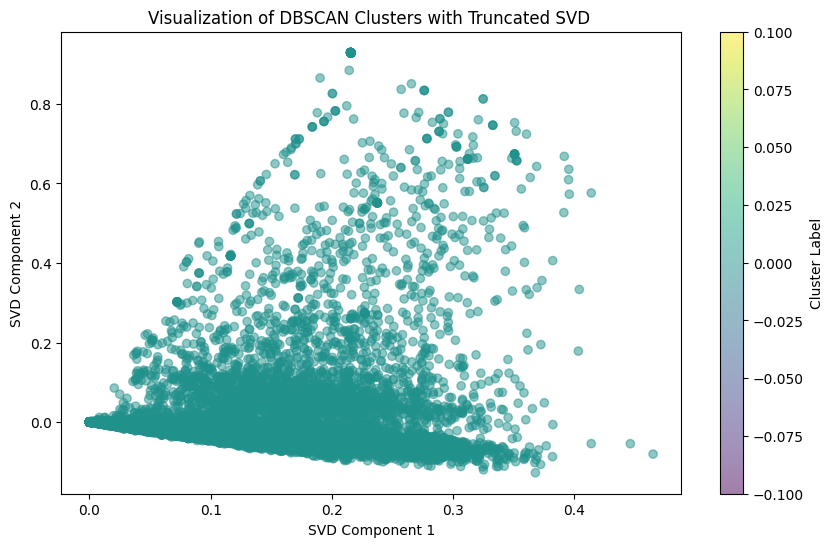

In [22]:

#definim svd
svd = TruncatedSVD(n_components=2)  #reducem la 2 componente
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

# initializare dbscan si antrenare
dbscan = DBSCAN(eps=0.8, min_samples=2)
dbscan.fit(X_train_svd) 

labels = dbscan.labels_

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.title('Visualization of DBSCAN Clusters with Truncated SVD ')
plt.colorbar(label='Cluster Label')
plt.show()


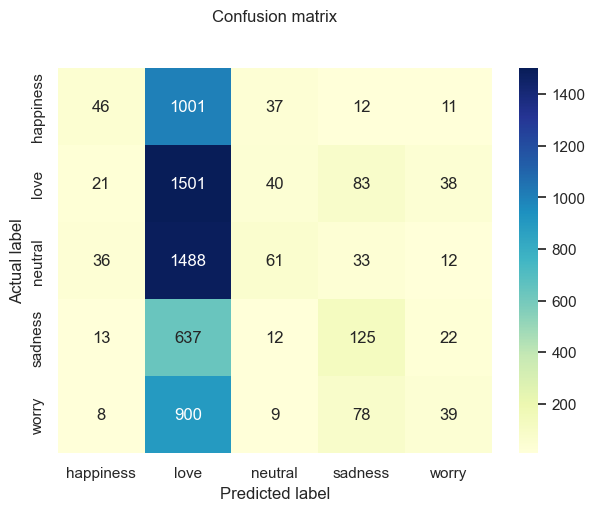

In [44]:
# Import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# calcularea matricei de confuzie
cnf_matrix = metrics.confusion_matrix(y_test, mapped_test_labels)

nume_clase = ['happiness', 'love', 'neutral', 'sadness', 'worry']

# creare heatmap
plt.figure(figsize=(7, 5)) 
sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu", fmt='g', 
            xticklabels=nume_clase, yticklabels=nume_clase)
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()